# Customer Segmentation using Clustering


In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score 
import numpy as np
from sklearn.decomposition import PCA

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [5]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

C:\Users\navee\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [9]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\navee\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 


<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>


In [11]:
df=df_offers.merge(df_transactions)

matrix=df.pivot_table(index='customer_name', columns=['offer_id'], values=['n'])
matrix=matrix.fillna(0)
matrix


n                                               ...       \
offer_id        1    2    3    4    5    6    7    8    9    10  ...   23   
customer_name                                                    ...        
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  0.0   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Williams       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
Wilson         0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
Wood           1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
Wright         0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0   
Young          0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0   

                                                            
offer_id        24   25   26   27   28   29   30   31   32  
customer_name                                               
Adams          0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
Allen          0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Anderson       1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
Baker          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  
Williams       0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
Wilson         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
Wood           0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
Wright         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Young          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  

[100 rows x 32 columns]

In [17]:
x_cols=matrix.values
x_cols

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Text(0, 0.5, 'SS')

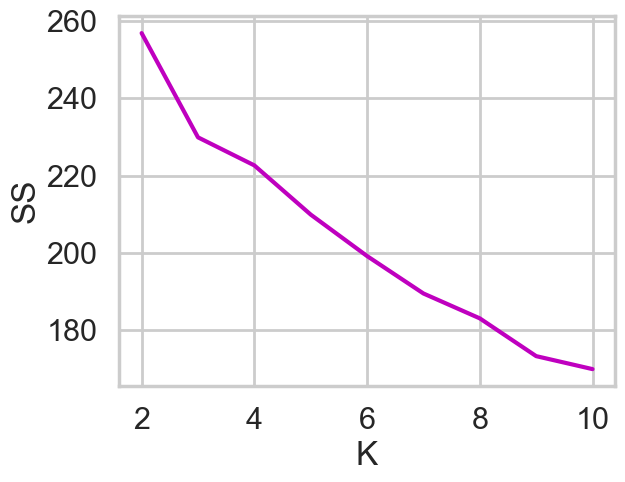

In [19]:
K=list(range(2,11))
y=[]
for i in K:
    kmeans=KMeans(n_clusters=i, random_state=1, init='k-means++')
    kmeans.fit(x_cols)
    labels=kmeans.labels_
    y.append(kmeans.inertia_)
    
plt.plot(K ,y, color='m')
plt.xlabel('K')
plt.ylabel('SS')

C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'size')

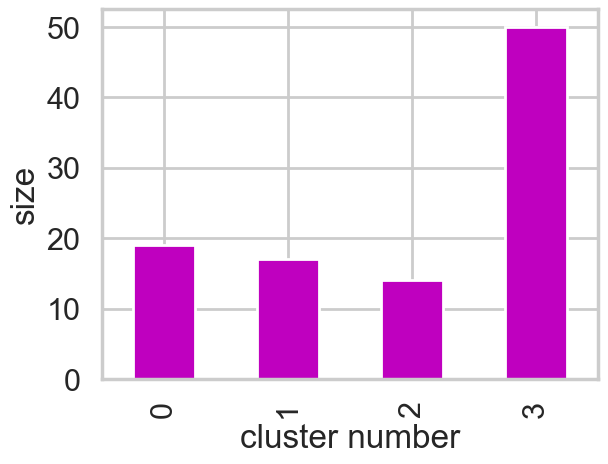

In [21]:
## Elbow point where slope of line is lower = 4
cluster=KMeans(n_clusters=4, random_state=1)
matrix['cluster']=cluster.fit_predict(x_cols)
matrix.cluster.value_counts().sort_index().plot(kind='bar', color='m')
plt.xlabel('cluster number')
plt.ylabel('size')


### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.


<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>


C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

[0.10855892949493119, 0.1157956147398056, 0.06538574770464416, 0.0834103244857216, 0.09795035518585711, 0.10393843048316183, 0.10845118140344386, 0.11619756966678045, 0.11163640343590836]


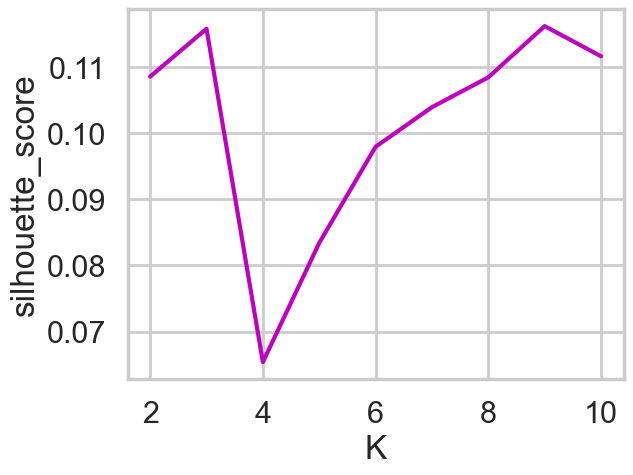

In [23]:
ys=[]
for i in K:
    kmeans=KMeans(n_clusters=i, random_state=1)
    kmeans.fit(x_cols)
    labels=kmeans.labels_
    ys.append(silhouette_score(x_cols, labels))
    
plt.plot(K ,ys, color='m')
plt.xlabel('K')
plt.ylabel('silhouette_score')
## best K=5
print(ys)

In [25]:
kmeans4=KMeans(n_clusters=4, random_state=1)    

In [39]:
## This function outputs pca_plot with input of matrix, x_col and clf is clustering method
def plot_pca(matrix, x_cols, clf):
    clf.fit(x_cols)
    labels=clf.labels_
    pca = sklearn.decomposition.PCA(n_components=2)
    pca.fit(matrix)
    new_matrix= pd.DataFrame(pca.transform(matrix))
    new_matrix.index = matrix.index
    new_matrix.columns=['x','y']
    new_matrix['labels']=labels

    sns.lmplot(x='x', y='y', hue='labels', data=new_matrix, fit_reg=False, height=5)

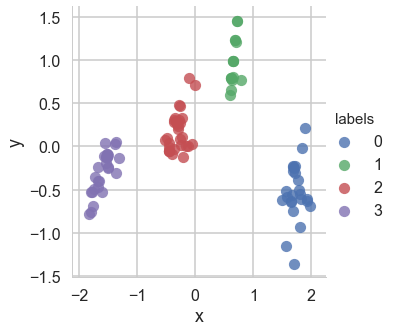

In [11]:
## Plot with K=4
plot_pca(matrix, x_cols, kmeans4)

C:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


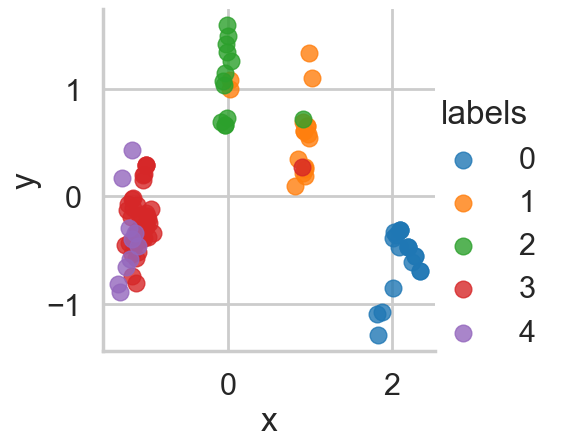

In [41]:
##Plot with K=5
kmeans5=KMeans(n_clusters=5, random_state=1)  
plot_pca(matrix, x_cols, kmeans5)

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.


<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>

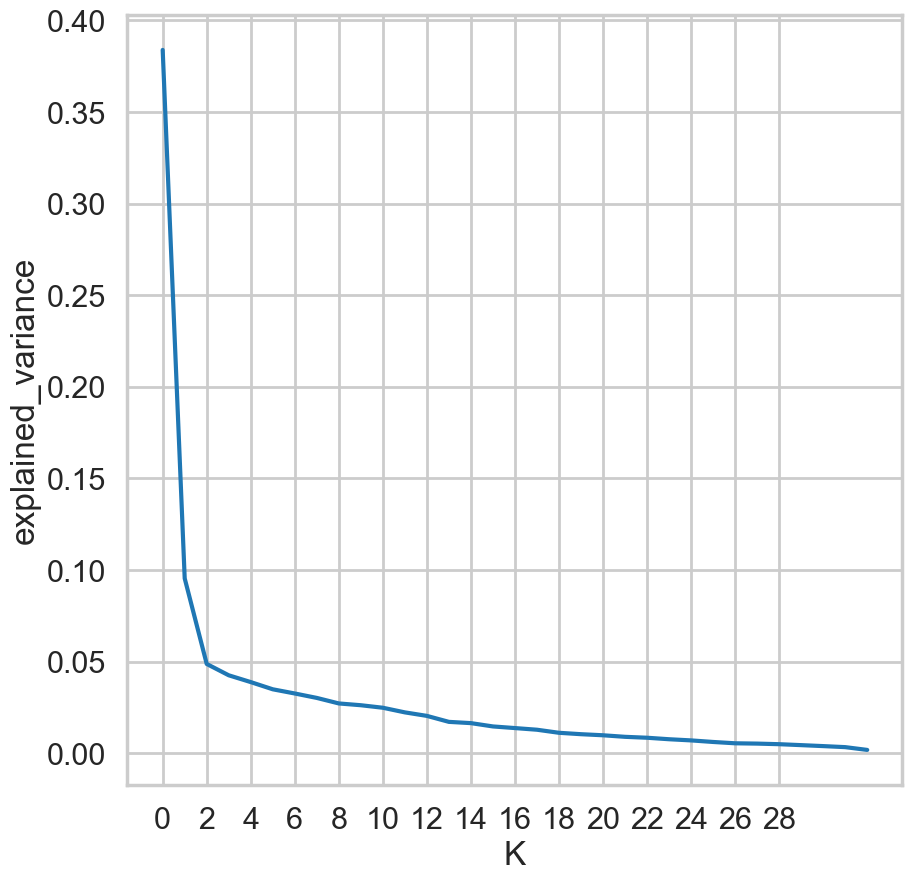

In [33]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
a=pca.fit(matrix).explained_variance_ratio_
fig, ax = plt.subplots(figsize=(10,10))
pd.Series(a).plot()
plt.xlabel('K')
plt.ylabel('explained_variance')
ax.set_xticks(np.arange(0,30,2))

#best K=4

In [17]:
## Spectral Clustering with PCA
SC=SpectralClustering(n_clusters=4)
SC.fit(x_cols)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=4, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=None)

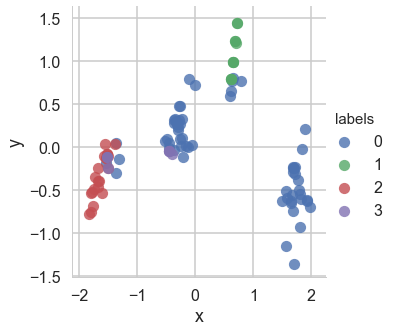

In [18]:
plot_pca(matrix, x_cols, SC)

In [19]:
## Agglomerative Clustering

In [35]:
AC=AgglomerativeClustering(n_clusters=4)
AC.fit(x_cols)

AgglomerativeClustering(n_clusters=4)

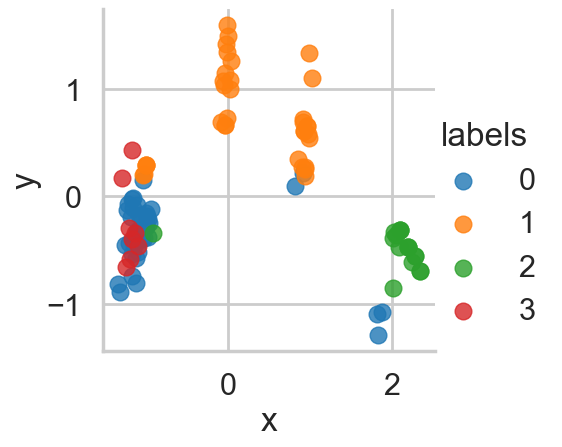

In [43]:
plot_pca(matrix, x_cols, AC)